In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
from datetime import datetime, timedelta
from scipy import signal
from scipy.signal import butter, filtfilt, hilbert, welch
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)

for dirname, _, filenames in os.walk('datasets1'):
    dataFile_quant = np.empty(len(filenames), dtype='object')
    for ii, filename in enumerate(filenames, start=0):
        dataFile_quant[ii] = (os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

featuresDF = pd.DataFrame(columns=['time', 'signal', 'inPhase', 'quadrature', 'frequency', 'amplitude', 'phase', 'snr'])
for ii in range(len(dataFile_quant)):
    df_time = np.transpose(np.array(pd.read_csv(dataFile_quant[ii], header= None, usecols=[0], dtype='float64')))[0]
    df_gen = np.transpose(np.array(pd.read_csv(dataFile_quant[ii], header= None, usecols=[1], dtype='float64')))[0]
    analytical_data = hilbert(df_gen)
    df_ip = analytical_data.real
    df_quad = analytical_data.imag
    df_freq  = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[5])
    df_amp   = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[7])
    df_phase = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[9])
    df_snr =   int(os.path.split(dataFile_quant[867])[1].split('.csv')[0].split('_')[11])
    featuresDF = featuresDF.append({'time': df_time,
                                    'signal': df_gen, 
                                    'inPhase': df_ip, 'quadrature': df_quad,
                                    'frequency': df_freq,
                                    'amplitude': df_amp, 'phase': df_phase,
                                    'snr': df_snr}, ignore_index=True)

#featuresDF['frequency'] = pd.to_numeric(featuresDF['frequency'])
featuresDF['snr'] = pd.to_numeric(featuresDF['snr'])
print(featuresDF.head())
print("\nData Types")
print(featuresDF.dtypes)

featuresDF.to_pickle('dataFrames/featuresDF1.p')

In [4]:
featuresDF = pd.read_pickle('dataFrames/featuresDF2.p')
print(featuresDF.head())

                                                time  \
0  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
1  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
2  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
3  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
4  [0.0, 5.0025012506253105e-09, 1.00050025012506...   

                                              signal  \
0  [-0.0492304625580017, 0.0327030924190087, 0.09...   
1  [0.0527251765934891, 0.017049429611942, -0.040...   
2  [-0.0085385153947489, 0.0543612558972888, 0.07...   
3  [-0.0097275397961656, 0.0307058247435442, 0.04...   
4  [-0.0409156108864265, 0.0013119497930588, 0.00...   

                                             inPhase  \
0  [-0.04923046255800172, 0.03270309241900869, 0....   
1  [0.05272517659348908, 0.017049429611941985, -0...   
2  [-0.008538515394748905, 0.05436125589728879, 0...   
3  [-0.009727539796165604, 0.030705824743544205, ...   
4  [-0.0409156108864265, 0.0013119497930588011

In [5]:
fs = 200e6        # Simulation sampling rate (Hz)
fs_adc = 100e6    # ADC sampling rate (Hz)
t_end = 1e-5     # Simulation end time (seconds)
t = np.linspace(0, t_end, int(fs*t_end))
print("There are {} elements per sample".format(len(t)))

There are 2000 elements per sample


In [6]:
# Which Figure to show for examples
showFig = 100

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


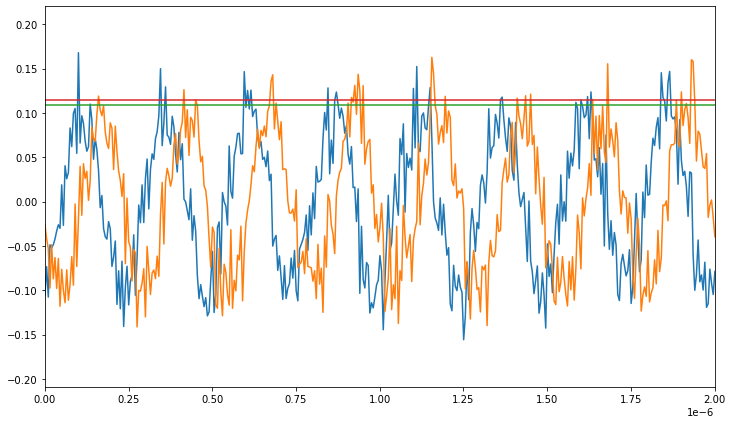

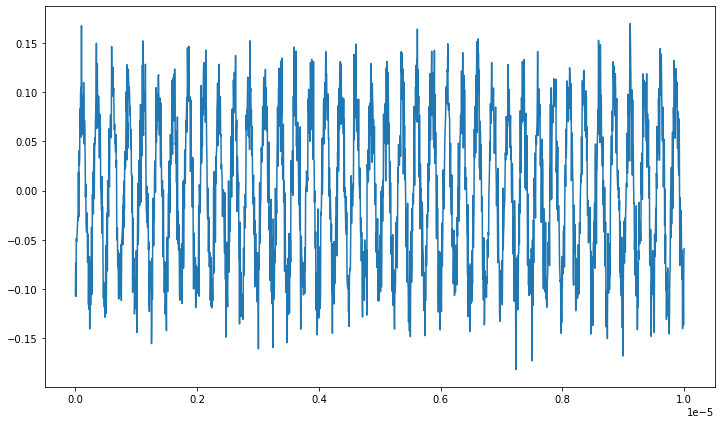

In [7]:
#IQ Data testing
def FilteredSignal(signal, fs, cutoff):
    B, A = butter(1, cutoff / (fs / 2), btype='low')
    filtered_signal = filtfilt(B, A, signal, axis=0)
    return filtered_signal

time = featuresDF.at[showFig, 'time']
testdata = featuresDF.at[showFig, 'signal']
cutoff = featuresDF.at[showFig, 'frequency']
analytical_testdata = hilbert(testdata)
amplitudeEnvelope = np.abs(analytical_testdata)
filteredSignal = FilteredSignal(amplitudeEnvelope, fs, cutoff)

print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.xlim(0,2e-6)
plt.plot(time, analytical_testdata.real)
plt.plot(time, analytical_testdata.imag)
plt.plot(amplitudeEnvelope)
plt.plot(filteredSignal)

plt.figure(figsize=(12,7))
plt.plot(time, testdata)

In [8]:
iq_sig = featuresDF.at[showFig, 'inPhase']*np.cos(2*np.pi*fs*t) - featuresDF.at[showFig, 'quadrature']*np.sin(2*np.pi*fs*t)

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


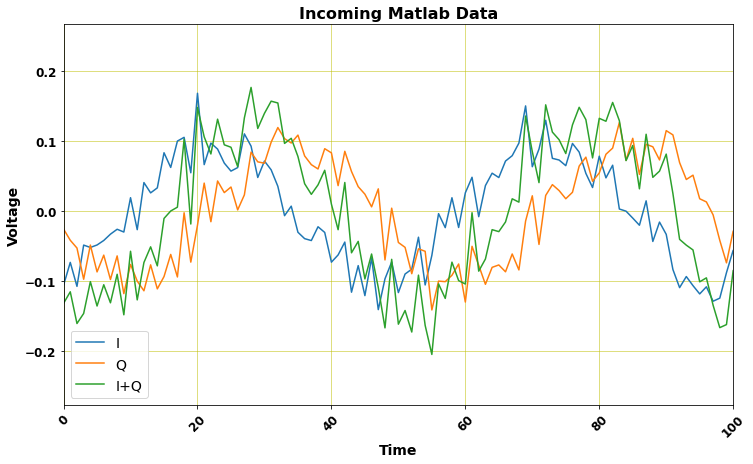

In [9]:
print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.plot(featuresDF.at[showFig, 'inPhase'])
plt.plot(featuresDF.at[showFig, 'quadrature'])
plt.plot(featuresDF.at[showFig, 'inPhase'] + featuresDF.at[showFig, 'quadrature'])
plt.legend(['I', 'Q', 'I+Q'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


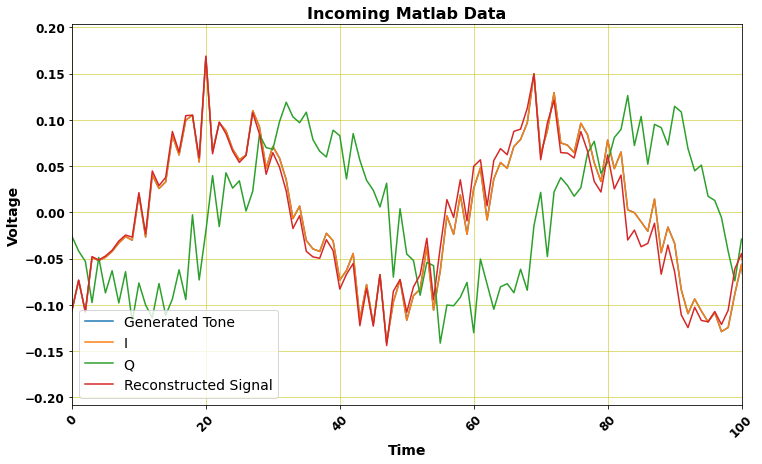

In [10]:
print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.plot(featuresDF.at[showFig, 'signal'])
plt.plot(featuresDF.at[showFig, 'inPhase'])
plt.plot(featuresDF.at[showFig, 'quadrature'])
plt.plot(iq_sig)
plt.legend(['Generated Tone', 'I', 'Q', 'Reconstructed Signal'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


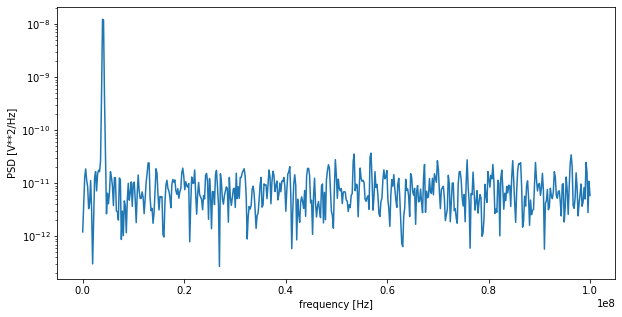

In [11]:
f, Pxx_den = welch(featuresDF.at[showFig,'signal'], fs, nperseg=1024)

print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape data
signal_df_r = featuresDF
signal_df_r['iq'] = ''
for ii in range(0, len(signal_df_r)):
    signal_sample = signal_df_r.at[ii,'signal']
    i_sample = signal_df_r.at[ii,'inPhase']
    q_sample = signal_df_r.at[ii,'quadrature']

    # Normalize the dataset
    signal_sample = np.asarray(signal_sample).reshape(-1,1)
    i_sample = np.asarray(i_sample).reshape(-1,1)
    q_sample = np.asarray(q_sample).reshape(-1,1)

    signal_sample = scaler.fit_transform(signal_sample)
    #i_sample = scaler.fit_transform(i_sample)
    #q_sample = scaler.fit_transform(q_sample)

    #signal_sample = signal_sample.reshape(width, height, 1)
    #signal_sample = signal_sample.reshape(50, 40, 1)
    signal_df_r.at[ii,'signal'] = np.array(signal_sample).squeeze()

    iq_sample = np.concatenate([i_sample, q_sample], axis=1)

    #iq_sample = signal_sample.reshape((iq_sample.shape[0], iq_sample.shape[1], 1))
    iq_sample = np.expand_dims(iq_sample, 2)
    signal_df_r.at[ii,'iq'] = np.array(iq_sample)

In [13]:
print(signal_df_r.shape)
print(signal_df_r.at[showFig,'iq'].shape)
print(signal_df_r.at[showFig,'signal'].shape)

(14000, 9)
(2000, 2, 1)
(2000,)


In [14]:
#Split the dataset 
from sklearn.model_selection import train_test_split 
train_df, test_validation_df = train_test_split(signal_df_r, train_size=0.8, test_size=0.2, random_state = 42, shuffle=True)
valid_df, test_df = train_test_split(test_validation_df, train_size=0.5, test_size=0.5, random_state = 42, shuffle=True)
print("Shape of train inputs {}, train target {}".format(train_df['signal'].iloc[0].shape, train_df.shape))
print("Shape of validation inputs {}, validation target {}".format(valid_df['signal'].iloc[0].shape, valid_df.shape))
print("Shape of test inputs {}, test target {}".format(test_df['signal'].iloc[0].shape, test_df.shape))

Shape of train inputs (2000,), train target (11200, 9)
Shape of validation inputs (2000,), validation target (1400, 9)
Shape of test inputs (2000,), test target (1400, 9)


In [15]:
train_features = np.array(train_df.iq.to_list()).squeeze()
valid_features = np.array(valid_df.iq.to_list()).squeeze()
test_features = np.array(test_df.iq.to_list()).squeeze()

train_labels = np.array(train_df.amplitude.to_list())
valid_labels = np.array(valid_df.amplitude.to_list())
test_labels = np.array(test_df.amplitude.to_list())

In [16]:
print(train_features.shape)
print(train_labels.shape)

(11200, 2000, 2)
(11200,)


In [17]:
for ii in range(len(train_labels)):
    print(f"Index: {ii} | Amp Val: {train_labels[ii]}")

Index: 0 | Amp Val: 0.4
Index: 1 | Amp Val: 0.7
Index: 2 | Amp Val: 0.6
Index: 3 | Amp Val: 1.0
Index: 4 | Amp Val: 0.5
Index: 5 | Amp Val: 0.4
Index: 6 | Amp Val: 0.4
Index: 7 | Amp Val: 0.4
Index: 8 | Amp Val: 1.0
Index: 9 | Amp Val: 0.4
Index: 10 | Amp Val: 0.5
Index: 11 | Amp Val: 0.9
Index: 12 | Amp Val: 0.2
Index: 13 | Amp Val: 0.1
Index: 14 | Amp Val: 0.6
Index: 15 | Amp Val: 0.5
Index: 16 | Amp Val: 0.9
Index: 17 | Amp Val: 0.9
Index: 18 | Amp Val: 0.3
Index: 19 | Amp Val: 0.3
Index: 20 | Amp Val: 0.4
Index: 21 | Amp Val: 0.9
Index: 22 | Amp Val: 0.5
Index: 23 | Amp Val: 0.7
Index: 24 | Amp Val: 0.3
Index: 25 | Amp Val: 0.3
Index: 26 | Amp Val: 1.0
Index: 27 | Amp Val: 0.1
Index: 28 | Amp Val: 0.4
Index: 29 | Amp Val: 0.4
Index: 30 | Amp Val: 0.3
Index: 31 | Amp Val: 0.2
Index: 32 | Amp Val: 0.7
Index: 33 | Amp Val: 0.8
Index: 34 | Amp Val: 0.4
Index: 35 | Amp Val: 0.1
Index: 36 | Amp Val: 0.1
Index: 37 | Amp Val: 0.9
Index: 38 | Amp Val: 0.7
Index: 39 | Amp Val: 0.8
Index: 40 

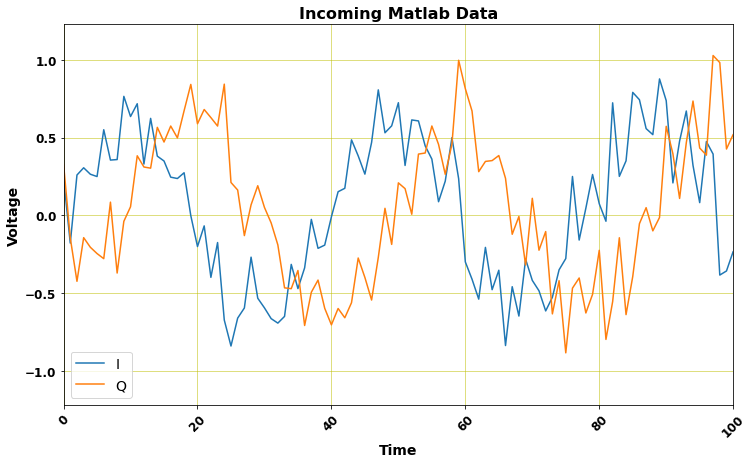

In [18]:
plt.figure(figsize=(12,7))
plt.plot(train_features[showFig,:,0]) #inPhase
plt.plot(train_features[showFig,:,1]) #quadrature
plt.legend(['I', 'Q'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

In [19]:
#Import TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, \
                                    ReLU, LeakyReLU, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

#ADDED CONFIG OPTIONS FOR STABILTY
#TensorFlow allocating all of the GPU memory 
#to itself when it initialises the session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#Reset Default graph - Needed only for Jupyter Notebook
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(42)

In [20]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [21]:
# Model configuration
batch_size = 1024
no_epochs = 300
verbosity = 1

In [22]:
modelType = "DNN"
modelName = "nanoConvPaper_v3.2.4_amp_tuned"
logDir = "logging" + "\\" + modelType + "\\" + modelName

In [23]:
modelDir = 'models'
modelSaveFile = modelDir + "\\" + modelType + "\\" + modelName + '.h5'

#Initialize model

initializer = tf.keras.initializers.GlorotUniform()
regulizer = tf.keras.regularizers.l2(l2=0.01)

#Add Layers
input_layer = Input(shape=(2000,2))
regressor = BatchNormalization()(input_layer)
regressor = Dense(2, kernel_initializer=initializer, kernel_regularizer=regulizer, activation='relu')(regressor)
regressor = Dropout(0.5)(regressor)
regressor = Dense(2, kernel_initializer=initializer, kernel_regularizer=regulizer, activation='relu')(regressor)
#regressor = BatchNormalization()(regressor)
regressor = Dropout(0.5)(regressor)
regressor = Dense(3, kernel_initializer=initializer, kernel_regularizer=regulizer, activation='relu')(regressor)
regressor = Flatten()(regressor)

amp_extract = Dense(1, activation=None, name='amp_extract')(regressor)

#Initialize model

#Add Layers
input_layer = Input(shape=(2000,2))
#regressor = BatchNormalization()(input_layer)
regressor = Dense(2, activation='relu')(input_layer)
#regressor = BatchNormalization()(regressor)
regressor = Dropout(0.5)(regressor)
regressor = Dense(2, activation='relu')(regressor)
regressor = Dropout(0.25)(regressor)
regressor = Dense(3, activation='relu')(regressor)
regressor = Flatten()(regressor)

amp_extract = Dense(1, activation=None, name='amp_extract')(regressor)

#Initialize model

#Add Layers
input_layer = Input(shape=(2000,2))

regressor = LSTM(1, return_sequences=True)(input_layer)
regressor = Flatten()(regressor)
#regressor = Dropout(0.5)(regressor)

regressor = Dense(3)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Dropout(0.5)(regressor)
regressor = Dense(2)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Dropout(0.25)(regressor)
regressor = Dense(2)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Flatten()(regressor)

amp_extract = Dense(1, activation=None, name='amp_extract')(regressor)

In [91]:
#Initialize model
initializer = tf.keras.initializers.GlorotUniform()
regulizer = tf.keras.regularizers.l2(l2=0.01)

#Add Layers
input_layer = Input(shape=(2000,2))

regressor = LSTM(1, return_sequences=True)(input_layer)
regressor = Flatten()(regressor)
#regressor = Dropout(0.5)(regressor)

regressor = Dense(3, kernel_initializer=initializer, kernel_regularizer=regulizer)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Dropout(0.5)(regressor)
regressor = Dense(2, kernel_initializer=initializer, kernel_regularizer=regulizer)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Dropout(0.25)(regressor)
regressor = Dense(2, kernel_initializer=initializer, kernel_regularizer=regulizer)(regressor)
regressor = LeakyReLU()(regressor)
#regressor = Flatten()(regressor)

amp_extract = Dense(1, activation=None, name='amp_extract')(regressor)

In [92]:
#Using Keras Model class
model = Model(inputs=input_layer,
              outputs=amp_extract) #Output layer added

In [93]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2000, 2)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 2000, 1)           16        
_________________________________________________________________
flatten_3 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6003      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 8         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 2)                 0   

In [94]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [95]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
#optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

In [96]:
model.compile(
            optimizer=optimizer, 
            loss='mse',
            metrics=['RootMeanSquaredError'],
            #metrics=['accuracy']
            )

In [97]:
es = EarlyStopping(monitor='val_root_mean_squared_error', #do not change
                   mode='min',  #do not change
                   min_delta=.0001,
                   verbose=1, # allows you to see more info per epoch
                   patience=25) # **** patience is how many validations to wait with nothing learned (patience * validation_freq)

mc = ModelCheckpoint(modelSaveFile, 
                     monitor='val_root_mean_squared_error', 
                     mode='min',
                     verbose=1, 
                     save_best_only=True)

In [107]:
#Setup Logging
logDir = "logging" + "\\" + modelType + "\\" + modelName + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logDir)

#Train the model
startTime = datetime.now().timestamp()
history = model.fit(
                train_features, train_labels,
                validation_data=(valid_features, valid_labels),
                epochs=no_epochs,
                callbacks=[tensorboard, es, mc],
                batch_size=batch_size,
                shuffle=True,
                verbose=verbosity)
executionTime = (datetime.now().timestamp() - startTime)
print(f"Training took {timedelta(seconds=executionTime)}")

Epoch 1/300
11/11 [==============================] - 2s 156ms/step - loss: 0.0287 - root_mean_squared_error: 0.0376 - val_loss: 0.0305 - val_root_mean_squared_error: 0.0521

Epoch 00001: val_root_mean_squared_error did not improve from 0.03029
Epoch 2/300
11/11 [==============================] - 1s 105ms/step - loss: 0.0734 - root_mean_squared_error: 0.2136 - val_loss: 0.0499 - val_root_mean_squared_error: 0.1396

Epoch 00002: val_root_mean_squared_error did not improve from 0.03029
Epoch 3/300
11/11 [==============================] - 1s 106ms/step - loss: 0.0397 - root_mean_squared_error: 0.1048 - val_loss: 0.0311 - val_root_mean_squared_error: 0.0546

Epoch 00003: val_root_mean_squared_error did not improve from 0.03029
Epoch 4/300
11/11 [==============================] - 1s 106ms/step - loss: 0.0321 - root_mean_squared_error: 0.0587 - val_loss: 0.0324 - val_root_mean_squared_error: 0.0518

Epoch 00004: val_root_mean_squared_error did not improve from 0.03029
Epoch 5/300
11/11 [=====

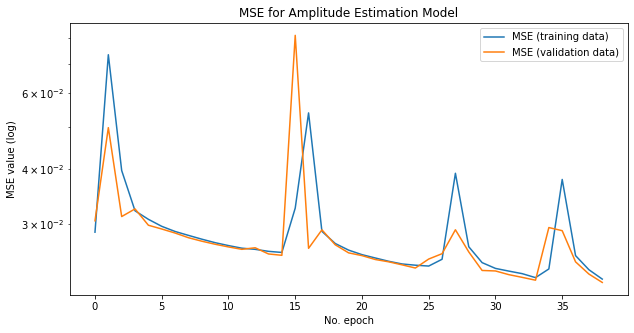

In [108]:
# Plot history: MSE
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.semilogy()
plt.title('MSE for Amplitude Estimation Model')
plt.ylabel('MSE value (log)')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

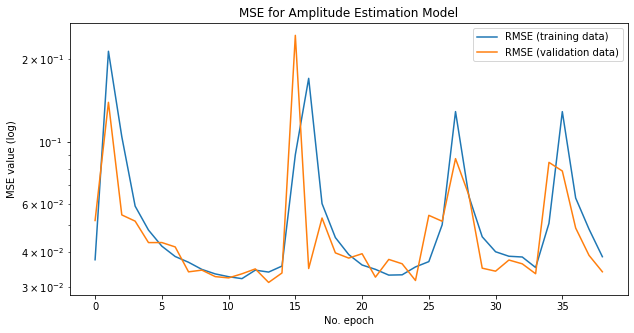

In [109]:
# Plot history: MSE
plt.figure(figsize=(10,5))
plt.plot(history.history['root_mean_squared_error'], label='RMSE (training data)')
plt.plot(history.history['val_root_mean_squared_error'], label='RMSE (validation data)')
plt.semilogy()
plt.title('MSE for Amplitude Estimation Model')
plt.ylabel('MSE value (log)')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

model.save(modelSaveFile)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logDir}

In [110]:
model = load_model(modelSaveFile)

In [111]:
amp_pred = model.predict(test_features)

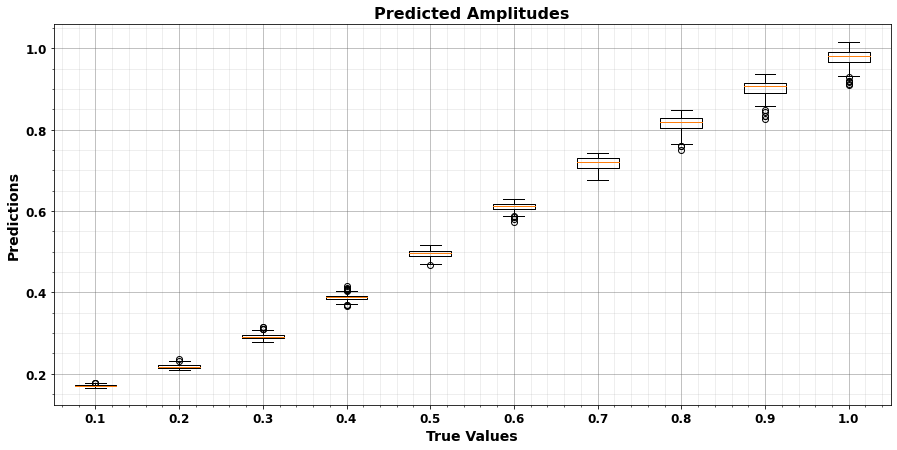

In [112]:
results = []
names = []
for amps in np.unique(test_labels):
    results.append(amp_pred[np.where(test_labels == amps)[0]].flatten())
    names.append(amps.round(2))
fig = plt.figure(figsize =(15, 7)) 
ax = fig.add_subplot(111)
bp = ax.boxplot(results)
plt.yticks(weight='bold', fontsize=12)
ax.set_xticklabels(names, weight='bold', fontsize=12)
plt.title('Predicted Amplitudes', weight='bold', fontsize=16)
plt.xlabel('True Values', weight='bold', fontsize=14)
plt.ylabel('Predictions', weight='bold', fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show(bp)

Text(0, 0.5, 'Predictions [frequency]')

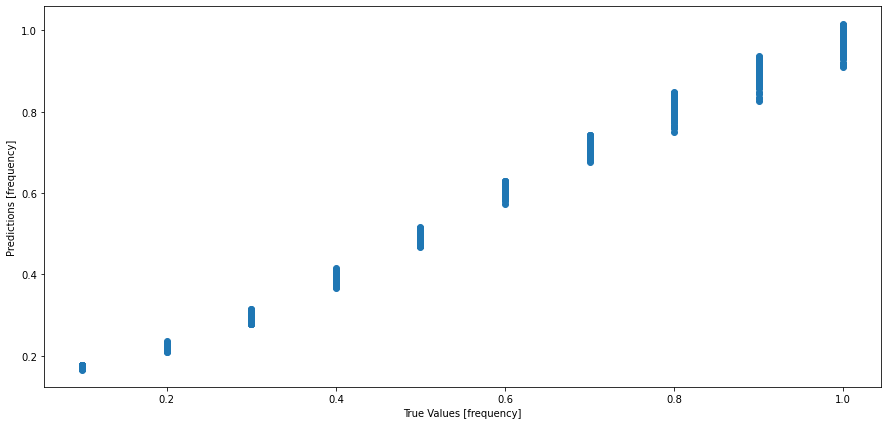

In [113]:
plt.figure(figsize =(15, 7)) 
plt.scatter(test_labels, amp_pred)
plt.xlabel('True Values [frequency]')
plt.ylabel('Predictions [frequency]')

In [114]:
mae = metrics.mean_absolute_error(test_labels, amp_pred)
mse = metrics.mean_squared_error(test_labels, amp_pred)
r2 = metrics.r2_score(test_labels, amp_pred)

print('R^2: ', r2)
print('MAE: ', mae)
print('MSE: ', mse)

R^2:  0.9899314939609035
MAE:  0.021597386185611994
MSE:  0.0008523033512835333


In [115]:
for num in np.arange(10):
    print("Predicted Amplitude {}: {},  Actual Amplitude {}: {}".format(num, round(float(amp_pred[num][0]),3), num, test_labels[num].round(3)))
#print("Predicted frequency 21: {}, Actual Frequency 21: {}".format(round(float(freq_pred[21][0]),3), test_freq_val[21].round(3)))

Predicted Amplitude 0: 0.218,  Actual Amplitude 0: 0.2
Predicted Amplitude 1: 0.497,  Actual Amplitude 1: 0.5
Predicted Amplitude 2: 0.168,  Actual Amplitude 2: 0.1
Predicted Amplitude 3: 0.289,  Actual Amplitude 3: 0.3
Predicted Amplitude 4: 0.285,  Actual Amplitude 4: 0.3
Predicted Amplitude 5: 0.981,  Actual Amplitude 5: 1.0
Predicted Amplitude 6: 0.387,  Actual Amplitude 6: 0.4
Predicted Amplitude 7: 0.901,  Actual Amplitude 7: 0.9
Predicted Amplitude 8: 0.706,  Actual Amplitude 8: 0.7
Predicted Amplitude 9: 0.615,  Actual Amplitude 9: 0.6


In [116]:
closeness_1 = np.zeros(len(amp_pred))
for ii in range(len(amp_pred)):
    if amp_pred[ii][0].round(1) == test_labels[ii].round(1):
        closeness_1[ii] = 1
amp_closeness = (np.count_nonzero(closeness_1)/len(amp_pred))*100
print('Frequency predictions on the test set were accurate to 1 decimal place by %{}'.format(round(amp_closeness,2)))

Frequency predictions on the test set were accurate to 1 decimal place by %20.21


In [117]:
avg_accuracy = np.zeros((len(amp_pred),2))
for ii in range(len(amp_pred)):
    avg_accuracy[ii,0] = test_labels[ii] - amp_pred[ii][0]
    avg_accuracy[ii,1] = (test_labels[ii] - amp_pred[ii][0]) / test_labels[ii] * 100

print('Average Amplitude Differed by {}Hz which was %{}'.format(avg_accuracy.mean(axis=0)[0].round(5), avg_accuracy.mean(axis=0)[1]))

Average Amplitude Differed by -0.00757Hz which was %-7.216215079755872


In [118]:
amp_pred_train = model.predict(train_features)

In [119]:
for num in np.arange(10):
    print("Predicted Amplitude {}: {},  Actual Amplitude {}: {}".format(num, round(float(amp_pred_train[num][0]),3), num, train_labels[num].round(3)))

Predicted Amplitude 0: 0.379,  Actual Amplitude 0: 0.4
Predicted Amplitude 1: 0.711,  Actual Amplitude 1: 0.7
Predicted Amplitude 2: 0.606,  Actual Amplitude 2: 0.6
Predicted Amplitude 3: 1.015,  Actual Amplitude 3: 1.0
Predicted Amplitude 4: 0.506,  Actual Amplitude 4: 0.5
Predicted Amplitude 5: 0.391,  Actual Amplitude 5: 0.4
Predicted Amplitude 6: 0.389,  Actual Amplitude 6: 0.4
Predicted Amplitude 7: 0.383,  Actual Amplitude 7: 0.4
Predicted Amplitude 8: 0.937,  Actual Amplitude 8: 1.0
Predicted Amplitude 9: 0.389,  Actual Amplitude 9: 0.4


In [120]:
closeness_1 = np.zeros(len(amp_pred_train))
for ii in range(len(amp_pred_train)):
    if amp_pred_train[ii][0].round(1) == train_labels[ii].round(1):
        closeness_1[ii] = 1
amp_closeness = (np.count_nonzero(closeness_1)/len(amp_pred_train))*100
print('Frequency predictions on the test set were accurate to 1 decimal place by %{}'.format(round(amp_closeness,2)))

Frequency predictions on the test set were accurate to 1 decimal place by %18.25


In [121]:
avg_accuracy = np.zeros((len(amp_pred_train),2))
for ii in range(len(train_labels)):
    avg_accuracy[ii,0] = train_labels[ii] - amp_pred_train[ii][0]
    avg_accuracy[ii,1] = (train_labels[ii] - amp_pred_train[ii][0]) / amp_pred_train[ii] * 100

print('Average Frequency Differed by {}Hz which was %{}'.format(avg_accuracy.mean(axis=0)[0].round(2), avg_accuracy.mean(axis=0)[1]))

Average Frequency Differed by -0.01Hz which was %-4.6184641303912
